**Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import keras
import tensorflow as tf
import random
from tensorflow.image import rgb_to_grayscale
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from keras.preprocessing.image import ImageDataGenerator
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

**Load Data**

In [2]:
!wget -O Data.npz https://zenodo.org/record/4269852/files/dermamnist.npz?download=1

--2024-07-01 19:52:48--  https://zenodo.org/record/4269852/files/dermamnist.npz?download=1
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.103.159, 188.184.98.238, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/4269852/files/dermamnist.npz [following]
--2024-07-01 19:52:48--  https://zenodo.org/records/4269852/files/dermamnist.npz
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 19725078 (19M) [application/octet-stream]
Saving to: ‘Data.npz’

Data.npz            100%[===================>]  18.81M  69.3MB/s    in 0.3s    

2024-07-01 19:52:48 (69.3 MB/s) - ‘Data.npz’ saved [19725078/19725078]



In [3]:
data = np.load('Data.npz')
print(data.files, "\n")

print(data['train_images'].shape)
print(data['train_images'].ndim, "\n")

print(data['val_images'].shape)
print(data['val_images'].ndim, "\n")

print(data['test_images'].shape)
print(data['test_images'].ndim, "\n")

#Podział 70% train, 10% val, 20% test

print(data['train_labels'].shape)
print(data['train_labels'].ndim, "\n")

print(data['val_labels'].shape)
print(data['val_labels'].ndim, "\n")

print(data['test_labels'].shape)
print(data['test_labels'].ndim, "\n")

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels'] 

(7007, 28, 28, 3)
4 

(1003, 28, 28, 3)
4 

(2005, 28, 28, 3)
4 

(7007, 1)
2 

(1003, 1)
2 

(2005, 1)
2 



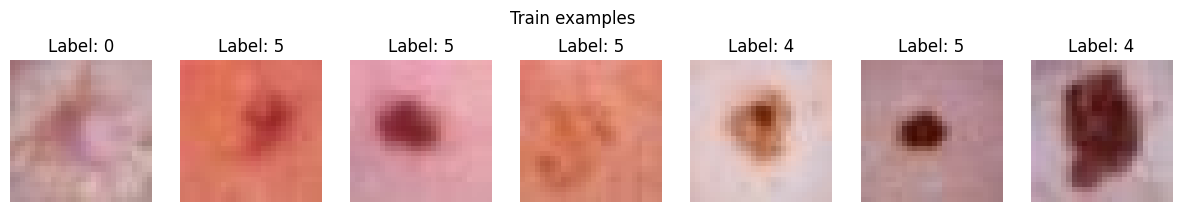

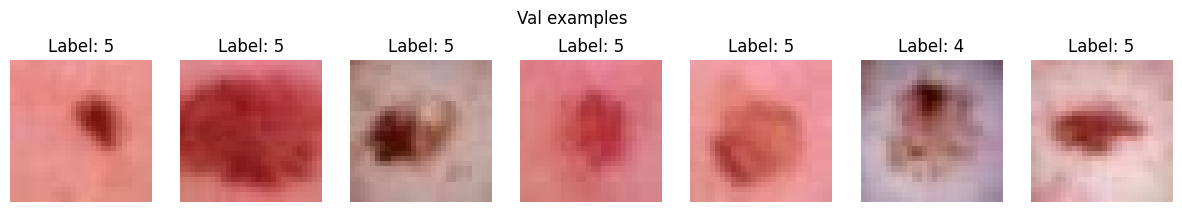

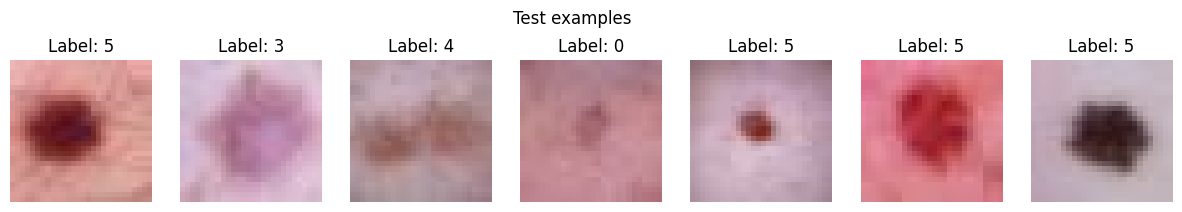

(7007,) 1
(1003,) 1
(2005,) 1


In [4]:
images_train = data['train_images']
labels_train = data['train_labels']

num_examples_train = 7
fig, axes = plt.subplots(1, num_examples_train, figsize=(15, 2.5))
fig.suptitle("Train examples")

for i in range(num_examples_train):
    axes[i].imshow(images_train[i])
    axes[i].set_title('Label: {}'.format(labels_train[i][0]))
    axes[i].axis('off')
plt.show()



images_val = data['val_images']
labels_val = data['val_labels']

num_examples_val = 7
fig, axes = plt.subplots(1, num_examples_val, figsize=(15, 2.5))
fig.suptitle("Val examples")

for i in range(num_examples_val):
    axes[i].imshow(images_val[i])
    axes[i].set_title('Label: {}'.format(labels_val[i][0]))
    axes[i].axis('off')
plt.show()



images_test = data['test_images']
labels_test = data['test_labels']

num_examples_test = 7
fig, axes = plt.subplots(1, num_examples_test, figsize=(15, 2.5))
fig.suptitle("Test examples")

for i in range(num_examples_test):
    axes[i].imshow(images_test[i])
    axes[i].set_title('Label: {}'.format(labels_test[i][0]))
    axes[i].axis('off')
plt.show()

labels_train = labels_train.reshape(data['train_images'].shape[0])#reshape klas treningowych z dwywymiarowej macierzy do jednowymiarowego wektora
labels_val = labels_val.reshape(data['val_images'].shape[0])#reshape klas walidacyjnych z dwywymiarowej macierzy do jednowymiarowego wektora
labels_test = labels_test.reshape(data['test_images'].shape[0])#reshape klas testowych z dwywymiarowej macierzy do jednowymiarowego wektora

print(labels_train.shape, labels_train.ndim)
print(labels_val.shape, labels_val.ndim)
print(labels_test.shape, labels_test.ndim)

**Number of records for individual classes**

[ 228  359  769   80  779 4693   99]


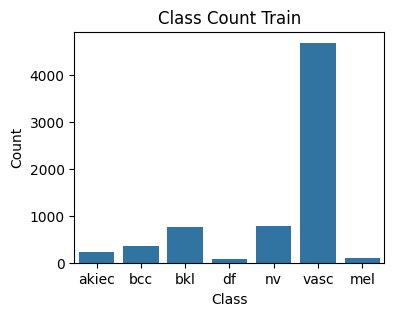

[ 33  52 110  12 111 671  14]


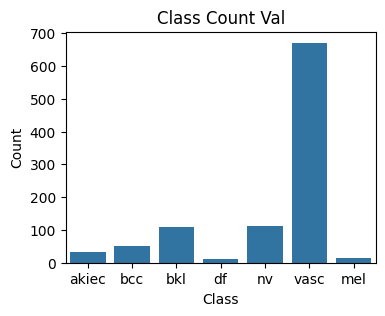

[  66  103  220   23  223 1341   29]


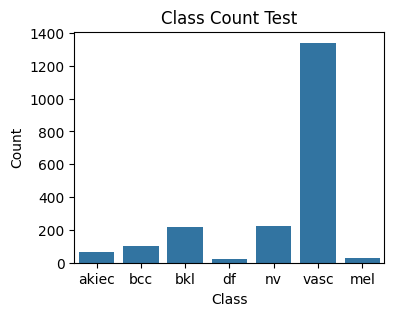

In [5]:
train_class_counts = np.bincount(labels_train)
print(train_class_counts)

class_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel']

plt.figure(figsize=(4, 3))
sns.barplot(x=class_labels, y=train_class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Count Train')
plt.show()



val_class_counts = np.bincount(labels_val)
print(val_class_counts)

class_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel']

plt.figure(figsize=(4, 3))
sns.barplot(x=class_labels, y=val_class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Count Val')
plt.show()



test_class_counts = np.bincount(labels_test)
print(test_class_counts)

class_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel']

plt.figure(figsize=(4, 3))
sns.barplot(x=class_labels, y=test_class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Count Test')
plt.show()

**Preprocessing for training set (grayscale, flattening, normalization)**

(7007, 28, 28, 1)


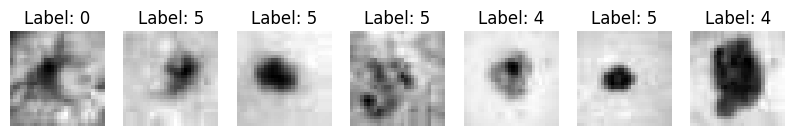

(7007, 28, 28, 1) 

(7007, 784) 

(7007, 784) 

[[125. 130. 135. ... 160. 155. 153.]
 [146. 141. 140. ... 147. 146. 145.]
 [180. 180. 179. ... 178. 178. 177.]
 ...
 [ 20.  54.  96. ... 115.  86.  57.]
 [154. 155. 157. ... 151. 149. 147.]
 [183. 179. 176. ... 180. 177. 174.]]
(7007, 784) 

tf.Tensor(
[[0.49  0.51  0.529 ... 0.627 0.608 0.6  ]
 [0.573 0.553 0.549 ... 0.576 0.573 0.569]
 [0.706 0.706 0.702 ... 0.698 0.698 0.694]
 ...
 [0.078 0.212 0.376 ... 0.451 0.337 0.224]
 [0.604 0.608 0.616 ... 0.592 0.584 0.576]
 [0.718 0.702 0.69  ... 0.706 0.694 0.682]], shape=(7007, 784), dtype=float32)


In [6]:
train_features = tf.image.rgb_to_grayscale(images_train)
train_labels_gray = labels_train
train_images_gray = train_features
random_state = 42
print(train_images_gray.shape)

num_examples_gray = 7
fig, axes = plt.subplots(1, num_examples_gray, figsize=(10, 2))
for i in range(num_examples_gray):
    axes[i].imshow(train_images_gray[i], cmap="gray")
    axes[i].set_title('Label: {}'.format(train_labels_gray[i]))
    axes[i].axis('off')

plt.show()
gray_train_features = train_features.numpy()
print(gray_train_features.shape, "\n")

flat_train_features = np.zeros((gray_train_features.shape[0], gray_train_features.shape[1] * gray_train_features.shape[2]))
print(flat_train_features.shape, "\n")

for i in range(gray_train_features.shape[0]):
    flat_train_features[i] = gray_train_features[i].reshape(gray_train_features.shape[1] * gray_train_features.shape[2])

print(flat_train_features.shape, "\n")
print(flat_train_features)

flat_train_scaled = flat_train_features

flat_train_scaled = np.round(flat_train_features / 255.0, 3)
flat_train_scaled = tf.image.convert_image_dtype(flat_train_scaled, tf.float32)

print(flat_train_scaled.shape, "\n")
print(flat_train_scaled)


**Preprocessing for test set (grayscale, flattening, normalization)**

(2005, 28, 28, 1)


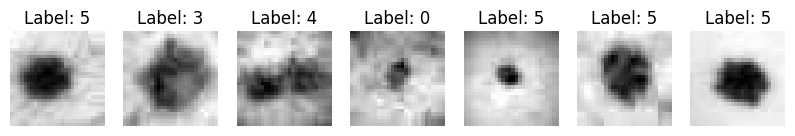

(2005, 28, 28, 1) 

(2005, 784) 

(2005, 784) 

[[198. 191. 192. ... 148. 152. 155.]
 [190. 191. 193. ... 194. 193. 196.]
 [152. 155. 158. ... 134. 131. 130.]
 ...
 [180. 181. 183. ... 174. 173. 172.]
 [178. 180. 182. ... 160. 166. 168.]
 [114. 122. 130. ... 147. 140. 136.]]
(2005, 784)
(2005,)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,labels
0,0.776,0.749,0.753,0.769,0.757,0.718,0.718,0.745,0.710,0.710,...,0.624,0.620,0.612,0.604,0.600,0.573,0.580,0.596,0.608,5
1,0.745,0.749,0.757,0.769,0.773,0.761,0.737,0.722,0.757,0.776,...,0.769,0.776,0.788,0.792,0.796,0.780,0.761,0.757,0.769,3
2,0.596,0.608,0.620,0.620,0.624,0.631,0.651,0.667,0.655,0.635,...,0.588,0.573,0.565,0.549,0.525,0.537,0.525,0.514,0.510,4
3,0.443,0.443,0.467,0.502,0.514,0.510,0.529,0.553,0.533,0.545,...,0.592,0.604,0.573,0.529,0.541,0.533,0.525,0.518,0.510,0
4,0.467,0.478,0.498,0.518,0.537,0.545,0.549,0.549,0.529,0.545,...,0.678,0.663,0.651,0.643,0.643,0.616,0.596,0.569,0.553,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000,0.710,0.710,0.718,0.725,0.722,0.718,0.729,0.745,0.733,0.737,...,0.718,0.718,0.671,0.643,0.667,0.694,0.698,0.702,0.706,2
2001,0.792,0.804,0.820,0.839,0.851,0.855,0.855,0.855,0.859,0.863,...,0.894,0.894,0.890,0.886,0.882,0.863,0.859,0.851,0.843,5
2002,0.706,0.710,0.718,0.725,0.729,0.729,0.729,0.729,0.733,0.737,...,0.686,0.686,0.686,0.686,0.686,0.686,0.682,0.678,0.675,5
2003,0.698,0.706,0.714,0.702,0.690,0.682,0.686,0.694,0.686,0.659,...,0.557,0.569,0.584,0.608,0.624,0.620,0.627,0.651,0.659,5


In [7]:
test_features = tf.image.rgb_to_grayscale(images_test)
test_labels_gray = labels_test
test_images_gray = test_features
print(test_images_gray.shape)

num_examples_gray = 7
fig, axes = plt.subplots(1, num_examples_gray, figsize=(10, 2))
for i in range(num_examples_gray):
    axes[i].imshow(test_images_gray[i], cmap="gray")
    axes[i].set_title('Label: {}'.format(test_labels_gray[i]))
    axes[i].axis('off')

plt.show()
gray_test_features = test_features.numpy()
print(gray_test_features.shape,"\n")

flat_test_features = np.zeros((gray_test_features.shape[0], gray_test_features.shape[1] * gray_test_features.shape[2]))
print(flat_test_features.shape, "\n")

for i in range(gray_test_features.shape[0]):
    flat_test_features[i] = gray_test_features[i].reshape(gray_test_features.shape[1] * gray_test_features.shape[2])

print(flat_test_features.shape, "\n")
print(flat_test_features)

flat_test_scaled = flat_test_features

flat_test_scaled = np.round(flat_test_features / 255.0, 3)
flat_test_scaled = tf.image.convert_image_dtype(flat_test_scaled, tf.float32)

df_test_features = pd.DataFrame(flat_test_scaled)
df_test_labels = pd.DataFrame(test_labels_gray)
df_test_labels = df_test_labels.rename(columns={0: 'labels'})
df_test = pd.concat([df_test_features, df_test_labels], axis=1)

df_test_split = df_test.copy()

X_test = df_test_split.drop(['labels'], axis=1)
y_test = df_test_split['labels']

print(X_test.shape)
print(y_test.shape)
df_test_split

**Final preparation of data for the classifier**

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
df_train_features = pd.DataFrame(flat_train_scaled)
df_train_labels = pd.DataFrame(train_labels_gray)
df_train_labels = df_train_labels.rename(columns={0: 'labels'})
df_train = pd.concat([df_train_features, df_train_labels], axis=1)

X_train = df_train.drop(['labels'], axis=1)
y_train = df_train['labels']

X_test = df_test_split.drop(['labels'], axis=1)
y_test = df_test_split['labels']

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7007, 784, 1)
(7007, 7)
(2005, 784, 1)
(2005, 7)


In [11]:
optimizer = keras.optimizers.Adam(learning_rate=0.0005)

model=Sequential()

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))
model.compile(optimizer = 'Adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)
callbacks = [learning_rate_reduction]

history = model.fit(
    X_train, y_train,
    epochs=80,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 784, 256)          1536      
                                                                 
 batch_normalization (Batch  (None, 784, 256)          1024      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 392, 256)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 392, 256)          327936    
                                                                 
 batch_normalization_1 (Bat  (None, 392, 256)          1024      
 chNormalization)                                                
                                                        

In [12]:
model.save('trained_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 1s 10ms/step
Accuracy: 0.713
Precision: 0.67
Recall: 0.713
F1 Score: 0.684


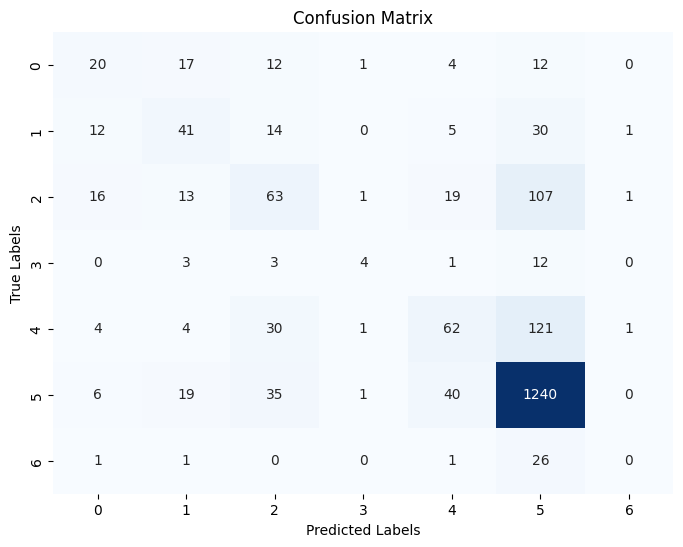

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.30      0.32        66
           1       0.42      0.40      0.41       103
           2       0.40      0.29      0.33       220
           3       0.50      0.17      0.26        23
           4       0.47      0.28      0.35       223
           5       0.80      0.92      0.86      1341
           6       0.00      0.00      0.00        29

    accuracy                           0.71      2005
   macro avg       0.42      0.34      0.36      2005
weighted avg       0.67      0.71      0.68      2005



In [13]:
loaded_model = load_model('trained_model.h5')

y_pred = loaded_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

accuracy = metrics.accuracy_score(y_true, y_pred_classes)
precision = metrics.precision_score(y_true, y_pred_classes, average='weighted')
recall = metrics.recall_score(y_true, y_pred_classes, average='weighted')
f1 = metrics.f1_score(y_true, y_pred_classes, average='weighted')

print("Accuracy:", round(accuracy, 3))
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("F1 Score:", round(f1, 3))

cm = metrics.confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

classification_report_result = metrics.classification_report(y_true, y_pred_classes)
print("Classification Report:")
print(classification_report_result)

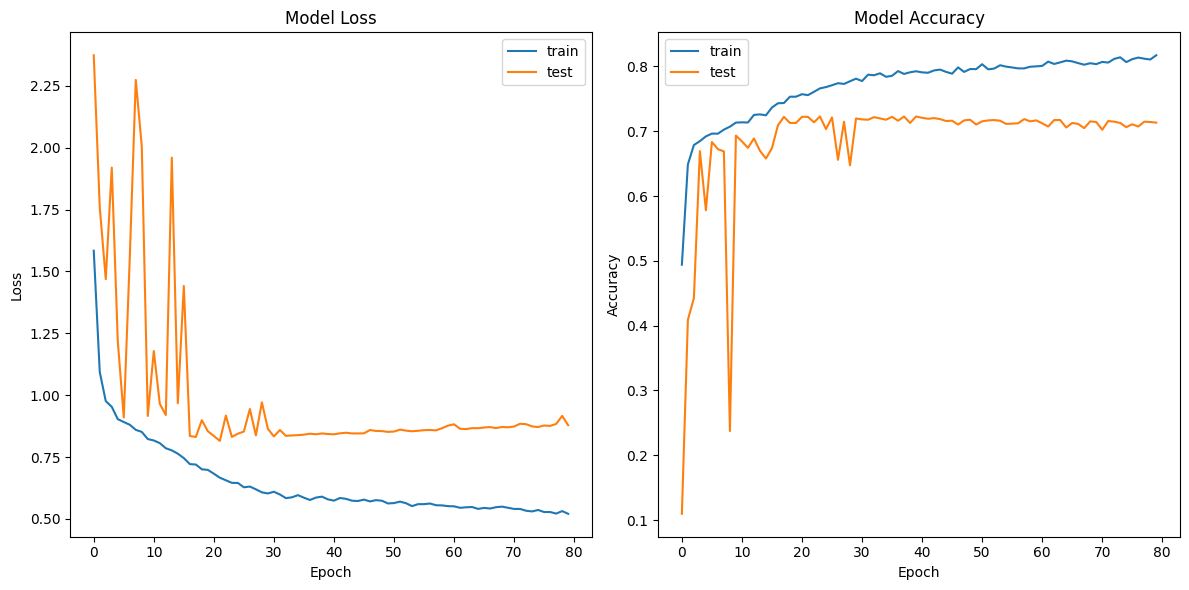

In [14]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()